In [15]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
# from keras.utils import np_utils
import tensorflow_datasets as tfds

In [16]:
def process_x(x):
    """Process the given tensors of images."""
    x = x.astype(np.float32)

    # The original data is in [0.0, 255.0].
    # This normalization helps in making them lie between [-1.0, 1.0].
    x /= 127.5 # Scale the pixel value from 0, 255 -> 0, 2
    x -= 1.0 # Shift the range to [-1, 1]

    # Add one dimension for the channels
    x = np.expand_dims(x, 3)
    return x

def load_data(ds=tf.keras.datasets.mnist):
    """Returns the processed dataset."""
    (train_images, train_labels), (test_images, test_labels) = ds.load_data()

    # Process the images for use
    train_images = process_x(train_images)
    test_images = process_x(test_images)

    return (train_images, train_labels), (test_images, test_labels)

(train_x, train_y), (test_x, test_y) = load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

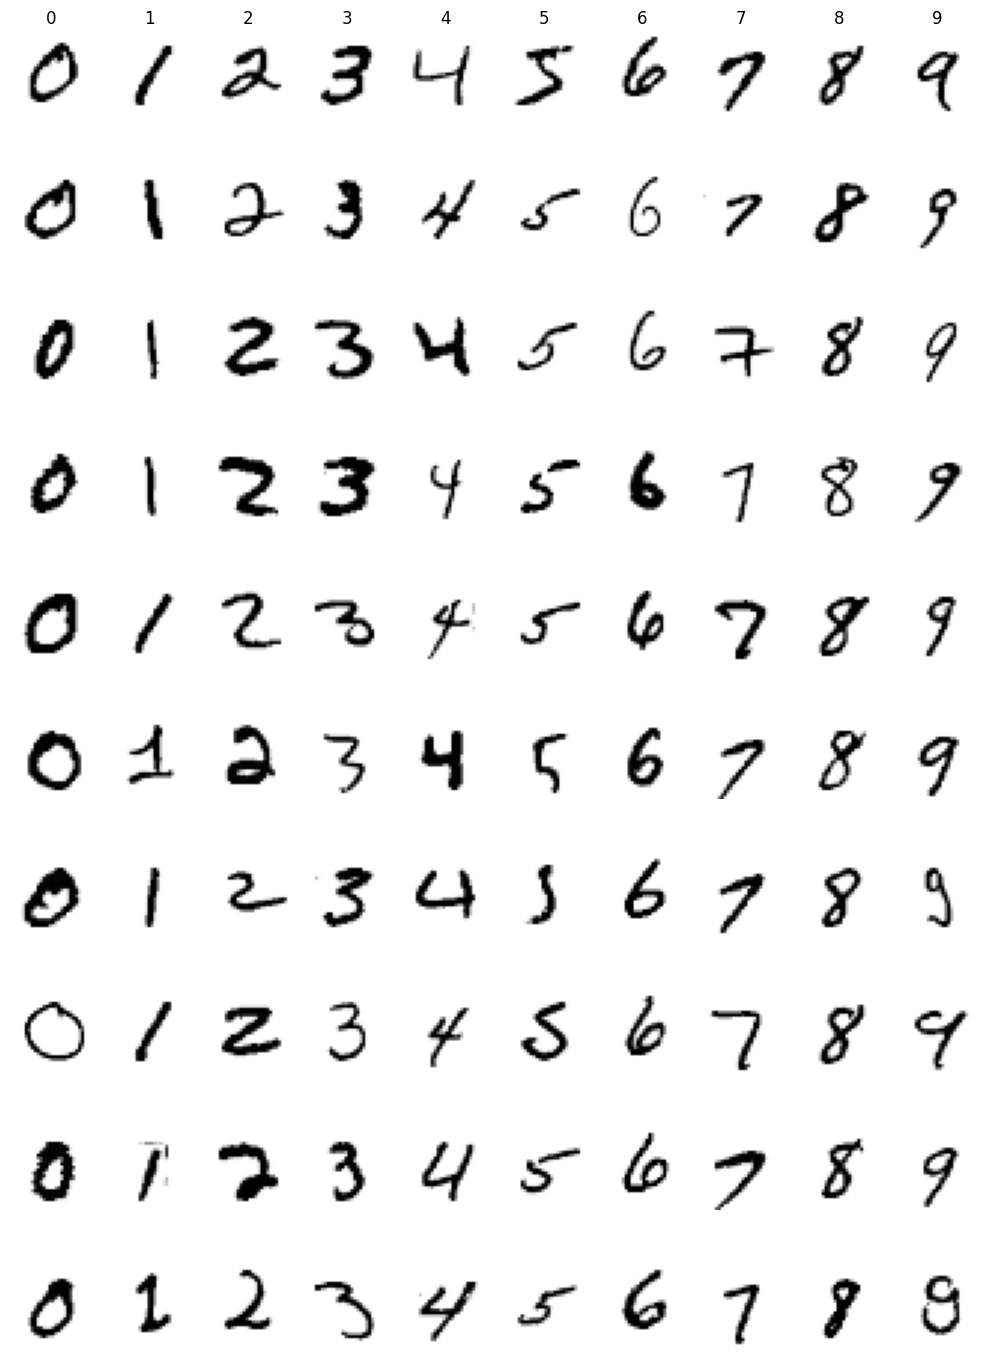

In [19]:
def collect_samples(x, y, num_classes=10, num_per_class=5):
    sampled_x = None
    sampled_x_idx = 0
    for class_idx in range(num_classes):
        num_collected = 0
        for idx in range(len(x)):
            if num_collected == num_per_class:
                break
            if y[idx] != class_idx:
                continue

            if sampled_x is not None:
                sampled_x = np.concatenate((sampled_x, np.expand_dims(x[idx], 0)))
            else:
                sampled_x = np.expand_dims(x[idx], 0)
            sampled_x_idx = sampled_x_idx + 1
            num_collected = num_collected + 1

    return sampled_x

def show_images(images,  num_rows=1, titles=None):
    """Display a list of images in a single figure with matplotlib. """
    num_images = len(images)
    num_cols = num_images // num_rows 

    # Plot images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.25 * num_rows, 1.75 * num_cols))

    for i in range(num_images):
        ax = axes[i%num_cols, i//num_cols]
        ax.axis('off')
        ax.imshow(np.squeeze(images[i]), cmap='Greys')

        if i % num_cols == 0:
            ax.set_title('{}'.format(int(i / num_rows)))
    plt.show()

show_images(collect_samples(train_x, train_y, num_per_class=10), num_rows=10)



## Create model and compile model


In [20]:
import tensorflow.keras.layers as layers

In [26]:
def create_model(dropout_rate=0.0):
    """Create a simple convolutional network."""
    inputs = keras.Input(shape=(28, 28, 1))
    x = inputs
    x = layers.Conv2D(32, (3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Conv2D(64, (3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10)(x)
    return keras.Model(inputs=inputs, outputs=x)

def get_compiled_model():
    """Create a compiled model (with loss fn, optimizer, metrics, etc.)"""
    model = create_model()
    opt = keras.optimizers.Adam()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=opt, 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return model

model = get_compiled_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,210 (137.54 KB)

 Trainable params: 35,018 (136.79 KB)

 Non-trainable params: 192 (768.00 B)

## Training without TFLite Model Generation

In [28]:
def train_basic_model():
  model = get_compiled_model()
  model.summary()

  model_history = model.fit(
      train_x, 
      train_y, 
      batch_size=128, 
      epochs=15, 
      validation_data=(test_x, test_y),
      shuffle=True)

  return model, model_history.history

basic_mnist_model, basic_mnist_model_history = train_basic_model()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,210 (137.54 KB)

 Trainable params: 35,018 (136.79 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.3975 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.0755 - val_sparse_categorical_accuracy: 0.9788
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0560 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0494 - val_sparse_categorical_accuracy: 0.9838
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0454 - val_sparse_categorical_accuracy: 0.9862
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0321 - val_sparse_categorical_accuracy: 0.9902
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0256 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.0384 - val_sparse_categorical_accuracy: 0.9875
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0368 - val_sparse_categorical_accuracy:

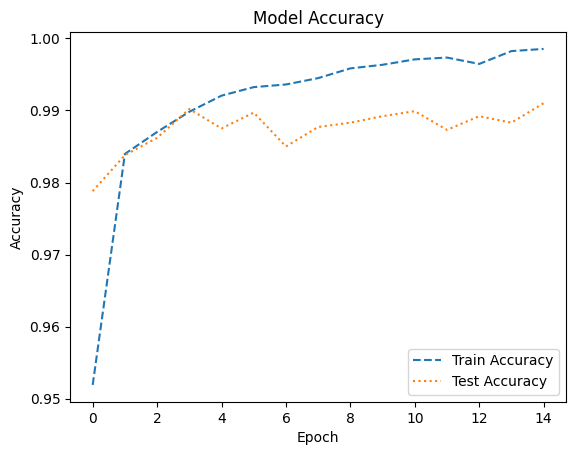

In [29]:

plt.plot(
    basic_mnist_model_history['sparse_categorical_accuracy'], 
    linestyle='dashed')
plt.plot(
    basic_mnist_model_history['val_sparse_categorical_accuracy'], 
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()
     
